In [1]:
import sys
import time
import datetime as dt
import warnings
import requests
import json
import math
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 120)

print(f"Pandas version: {pd.__version__}")
print(f"Python version: {'.'.join(list(map(str, sys.version_info[:3])))}")

print(dt.datetime.now().strftime("\n%Y-%m-%d %H:%M:%S"))

Pandas version: 1.1.3
Python version: 3.7.6

2020-11-29 02:24:59


In [2]:
temp = pd.read_csv("temp_volga_day.csv", sep=";")
temp["TEMP"] = round((temp["TEMP"] - 32) * 5 / 9, 1)
temp.describe()

YEAR        MONTH          DAY         TEMP        VISIB
count  2125.000000  2125.000000  2125.000000  2125.000000  2125.000000
mean   2017.477647     6.436235    15.654588     6.062306    28.033714
std       1.683277     3.410727     8.823293    11.256867    55.847506
min    2015.000000     1.000000     1.000000   -26.000000     2.421378
25%    2016.000000     3.000000     8.000000    -2.600000     7.740000
50%    2017.000000     6.000000    16.000000     6.400000     9.549506
75%    2019.000000     9.000000    23.000000    16.100000    11.270370
max    2020.000000    12.000000    31.000000    28.400000   448.533333

In [3]:
gen = pd.read_csv("gen_consum_volga.csv", sep=";")
gen.describe()

Unnamed: 0         YEAR        MONTH          DAY    E_USE_FACT  \
count  1854.000000  1854.000000  1854.000000  1854.000000   1854.000000   
mean    926.500000  2017.864617     6.586300    15.709817  41581.457751   
std     535.348018     1.476021     3.466725     8.793300   4394.955376   
min       0.000000  2015.000000     1.000000     1.000000  33321.097222   
25%     463.250000  2017.000000     4.000000     8.000000  37612.881944   
50%     926.500000  2018.000000     7.000000    16.000000  41320.194444   
75%    1389.750000  2019.000000    10.000000    23.000000  45593.013889   
max    1853.000000  2020.000000    12.000000    31.000000  50522.569444   

         E_USE_PLAN      GEN_FACT      GEN_PLAN  
count   1854.000000   1854.000000   1854.000000  
mean   41709.479339  42374.464237  42448.454925  
std     4401.777208   4528.160156   4535.835284  
min    33549.972222  34190.736111  34345.277778  
25%    37697.052083  38287.475694  38331.663194  
50%    41479.729167  42106.097222  42202.729167  
75%    45742.520833  46380.000000  46465.187500  
max    50498.486111  51630.180556  51752.736111

In [4]:
gen

Unnamed: 0  YEAR  MONTH  DAY    E_USE_FACT    E_USE_PLAN      GEN_FACT  \
0             50  2015     11    1  42143.708333  42361.861111  42841.069444   
1            111  2015     11    2  44020.416667  44185.013889  44369.458333   
2            172  2015     11    3  43557.458333  43789.402778  44103.597222   
3            233  2015     11    4  41836.666667  41947.555556  42709.250000   
4            294  2015     11    5  43676.013889  43787.541667  44245.125000   
...          ...   ...    ...  ...           ...           ...           ...   
1849        1397  2020     11   23  45955.402778  46201.444444  46319.180556   
1850        1458  2020     11   24  45784.166667  46032.333333  46151.722222   
1851        1519  2020     11   25  45824.166667  46044.013889  46059.055556   
1852        1580  2020     11   26  46075.694444  46288.097222  46399.583333   
1853        1641  2020     11   27  38926.819444  46495.569444  39125.402778   

          GEN_PLAN  
0     43125.194444  
1     44545.027778  
2     44295.055556  
3     42753.180556  
4     44369.958333  
...            ...  
1849  46458.763889  
1850  46198.305556  
1851  46212.083333  
1852  46499.736111  
1853  46751.972222  

[1854 rows x 8 columns]

In [5]:
izol = pd.read_csv("izol_volga_day.csv", sep=";")
izol_d = {dt.datetime(int(x["YEAR"]), int(x["MONTH"]), int(x["DAY"])):x["INDEX"] for _, x in izol.iterrows()}
izol.describe()

YEAR       MONTH         DAY       INDEX
count   278.0  278.000000  278.000000  278.000000
mean   2020.0    6.809353   15.856115    1.829871
std       0.0    2.640216    8.812578    0.750170
min    2020.0    2.000000    1.000000    0.830556
25%    2020.0    5.000000    8.000000    1.200309
50%    2020.0    7.000000   16.000000    1.505324
75%    2020.0    9.000000   23.750000    2.518596
max    2020.0   11.000000   31.000000    3.809414

In [6]:
izol

YEAR  MONTH  DAY     INDEX
0    2020      2   23  2.715741
1    2020      2   24  2.903395
2    2020      2   25  1.046605
3    2020      2   26  0.959105
4    2020      2   27  0.992901
..    ...    ...  ...       ...
273  2020     11   22  3.080093
274  2020     11   23  1.526080
275  2020     11   24  1.485802
276  2020     11   25  1.487809
277  2020     11   26  1.492593

[278 rows x 4 columns]

In [7]:
coms = pd.read_csv("sberindex_comsumer.csv", sep=";").groupby("Дата").mean().reset_index()
coms["DATE"] = pd.to_datetime(coms["Дата"], format="%Y-%m-%d")
coms["INDEX"] = coms["Значение"]
coms = coms[["DATE", "INDEX"]]
coms_d = {x["DATE"]:x["INDEX"] for _, x in coms.iterrows()}

In [8]:
coms.describe()

INDEX
count  362.000000
mean    70.261203
std     12.875730
min     15.222222
25%     63.111111
50%     72.722222
75%     79.638889
max    100.000000

In [9]:
coms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    362 non-null    datetime64[ns]
 1   INDEX   362 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [10]:
msp = pd.read_csv("sberindex_msp_activity.csv", sep=";").groupby("DATE").mean().reset_index()
msp["DATE"] = pd.to_datetime(msp["DATE"], format="%Y-%m-%d")
msp_d = {x["DATE"]:x["VALUE"] for _, x in msp.iterrows()}
msp.head()

DATE      VALUE
0 2020-03-02   1.044444
1 2020-03-09   0.944444
2 2020-03-16   0.788889
3 2020-03-23  -0.211111
4 2020-03-30 -12.700000

In [11]:
%%time

data = pd.DataFrame(columns=["YEAR", "MONTH", "DAY", "WEEKDAY", "USE_FACT", "TEMP", "VISIB", "II", "COMS", "MSP"])

def get_date(df, loc):
    return dt.datetime(int(df.loc[loc]["YEAR"]), int(df.loc[loc]["MONTH"]), int(df.loc[loc]["DAY"]))

temp_count = 0
date_temp = 0

ii_cur = 2
coms_cur = 70
msp_cur = 0


for k, v in gen.iterrows():
    yy = int(v["YEAR"])
    mm = int(v["MONTH"])
    dd = int(v["DAY"])
    
    date_gen = dt.datetime(yy, mm, dd)
    
    wd = date_gen.weekday()
    use = v["E_USE_FACT"]
    
    
    date_temp = get_date(temp, temp_count)
    while temp_count < len(temp) - 1 and date_temp < date_gen:
        temp_count += 1
        date_temp = get_date(temp, temp_count)
    

    if date_gen in izol_d:
        ii_cur = izol_d[date_gen]
    
    if date_gen in coms_d:
        coms_cur = coms_d[date_gen]

    if date_gen in msp_d:
        msp_cur = msp_d[date_gen]
        
    tt = temp.loc[temp_count]["TEMP"]
    vs = temp.loc[temp_count]["VISIB"]
    
   
    data.loc[k] = [yy, mm, dd, wd, use, tt, vs, ii_cur, coms_cur, msp_cur]


CPU times: user 3.51 s, sys: 0 ns, total: 3.51 s
Wall time: 3.51 s


In [12]:
data = data[:len(data) - 1]
data

YEAR  MONTH   DAY  WEEKDAY      USE_FACT  TEMP      VISIB        II  \
0     2015.0   11.0   1.0      6.0  42143.708333  -0.6   7.613333  2.000000   
1     2015.0   11.0   2.0      0.0  44020.416667   2.3   6.420000  2.000000   
2     2015.0   11.0   3.0      1.0  43557.458333   5.0   5.366667  2.000000   
3     2015.0   11.0   4.0      2.0  41836.666667   4.2   8.113333  2.000000   
4     2015.0   11.0   5.0      3.0  43676.013889   3.9   6.606667  2.000000   
...      ...    ...   ...      ...           ...   ...        ...       ...   
1848  2020.0   11.0  22.0      6.0  44145.444444  -7.0  10.424109  3.080093   
1849  2020.0   11.0  23.0      0.0  45955.402778  -7.0  10.424109  1.526080   
1850  2020.0   11.0  24.0      1.0  45784.166667  -7.0  10.424109  1.485802   
1851  2020.0   11.0  25.0      2.0  45824.166667  -7.0  10.424109  1.487809   
1852  2020.0   11.0  26.0      3.0  46075.694444  -7.0  10.424109  1.492593   

           COMS       MSP  
0     70.000000  0.000000  
1     70.000000  0.000000  
2     70.000000  0.000000  
3     70.000000  0.000000  
4     70.000000  0.000000  
...         ...       ...  
1848  59.222222  2.922222  
1849  69.111111  2.922222  
1850  70.444444  2.922222  
1851  73.888889  2.922222  
1852  74.666667  2.922222  

[1853 rows x 10 columns]

In [13]:
data_train = pd.DataFrame()
for r, d in data.iterrows():
    data_train.loc[r, "DATE"] = dt.datetime(int(d["YEAR"]), int(d["MONTH"]), int(d["DAY"]))
    data_train.loc[r, "MONTH"] = int(d["MONTH"])
    data_train.loc[r, "DAY"] = int(d["DAY"])
    data_train.loc[r, "WEEKDAY"] = int(d["WEEKDAY"])
    data_train.loc[r, "USE_FACT"] = d["USE_FACT"]
    data_train.loc[r, "TEMP"] = d["TEMP"]
    data_train.loc[r, "VISIB"] = d["VISIB"]
    data_train.loc[r, "II"] = d["II"]
    data_train.loc[r, "COMS"] = d["COMS"]
    data_train.loc[r, "MSP"] = d["MSP"]
data_train

DATE  MONTH   DAY  WEEKDAY      USE_FACT  TEMP      VISIB  \
0    2015-11-01   11.0   1.0      6.0  42143.708333  -0.6   7.613333   
1    2015-11-02   11.0   2.0      0.0  44020.416667   2.3   6.420000   
2    2015-11-03   11.0   3.0      1.0  43557.458333   5.0   5.366667   
3    2015-11-04   11.0   4.0      2.0  41836.666667   4.2   8.113333   
4    2015-11-05   11.0   5.0      3.0  43676.013889   3.9   6.606667   
...         ...    ...   ...      ...           ...   ...        ...   
1848 2020-11-22   11.0  22.0      6.0  44145.444444  -7.0  10.424109   
1849 2020-11-23   11.0  23.0      0.0  45955.402778  -7.0  10.424109   
1850 2020-11-24   11.0  24.0      1.0  45784.166667  -7.0  10.424109   
1851 2020-11-25   11.0  25.0      2.0  45824.166667  -7.0  10.424109   
1852 2020-11-26   11.0  26.0      3.0  46075.694444  -7.0  10.424109   

            II       COMS       MSP  
0     2.000000  70.000000  0.000000  
1     2.000000  70.000000  0.000000  
2     2.000000  70.000000  0.000000  
3     2.000000  70.000000  0.000000  
4     2.000000  70.000000  0.000000  
...        ...        ...       ...  
1848  3.080093  59.222222  2.922222  
1849  1.526080  69.111111  2.922222  
1850  1.485802  70.444444  2.922222  
1851  1.487809  73.888889  2.922222  
1852  1.492593  74.666667  2.922222  

[1853 rows x 10 columns]

In [14]:
%%time

BACK = 30
data_train3m = pd.DataFrame()
for r, d in data_train[:len(data_train3m) - 5].iterrows():
    if r > BACK:
        data_train3m.loc[r, "DATE"] = d["DATE"]
        data_train3m.loc[r, "MONTH"] = d["MONTH"]
        data_train3m.loc[r, "DAY"] = d["DAY"]
        data_train3m.loc[r, "WEEKDAY"] = d["WEEKDAY"]
        data_train3m.loc[r, "USE_FACT"] = d["USE_FACT"]
        data_train3m.loc[r, "TEMP"] = d["TEMP"]
        data_train3m.loc[r, "VISIB"] = d["VISIB"]

        data_train3m.loc[r, "USE_FACT1"]  = data_train.loc[r - 1, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT3"]  = data_train.loc[r - 3, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT5"]  = data_train.loc[r - 5, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT7"]  = data_train.loc[r - 7, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT14"] = data_train.loc[r - 14, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT30"] = data_train.loc[r - 30, "USE_FACT"]
    
        data_train3m.loc[r, "TEMP1"] = data_train.loc[r - 1]["TEMP"]
        data_train3m.loc[r, "TEMP3"] = data_train.loc[r - 3]["TEMP"]
        data_train3m.loc[r, "TEMP5"] = data_train.loc[r - 5]["TEMP"]
        data_train3m.loc[r, "TEMP7"] = data_train.loc[r - 7]["TEMP"]
        data_train3m.loc[r, "TEMP14"] = data_train.loc[r - 14]["TEMP"]
        data_train3m.loc[r, "TEMP30"] = data_train.loc[r - 30]["TEMP"]

        data_train3m.loc[r, "II"] = data_train.loc[r]["II"]
        data_train3m.loc[r, "II3"] = data_train.loc[r - 3]["II"]

        data_train3m.loc[r, "COMS"] = data_train.loc[r]["COMS"]
        data_train3m.loc[r, "COMS3"] = data_train.loc[r - 3]["COMS"]

        data_train3m.loc[r, "MSP"] = data_train.loc[r]["MSP"]
        
        data_train3m.loc[r, "USE_PRED1"]  = data_train.loc[r + 1, "USE_FACT"]
        data_train3m.loc[r, "USE_PRED2"]  = data_train.loc[r + 2, "USE_FACT"]
        data_train3m.loc[r, "USE_PRED3"]  = data_train.loc[r + 3, "USE_FACT"]
        data_train3m.loc[r, "USE_PRED4"]  = data_train.loc[r + 4, "USE_FACT"]
        data_train3m.loc[r, "USE_PRED5"]  = data_train.loc[r + 5, "USE_FACT"]
        
data_train3m

CPU times: user 12.4 s, sys: 10.9 ms, total: 12.4 s
Wall time: 12.4 s


DATE  MONTH   DAY  WEEKDAY      USE_FACT  TEMP      VISIB  \
31   2015-12-02   12.0   2.0      2.0  45997.125000  -0.4   6.756667   
32   2015-12-03   12.0   3.0      3.0  46161.666667  -1.4   7.063333   
33   2015-12-04   12.0   4.0      4.0  46242.638889  -1.5   7.700000   
34   2015-12-05   12.0   5.0      5.0  44494.750000  -1.0   5.286667   
35   2015-12-06   12.0   6.0      6.0  43615.013889   1.1   5.370000   
...         ...    ...   ...      ...           ...   ...        ...   
1843 2020-11-17   11.0  17.0      1.0  45955.527778 -11.0  10.179250   
1844 2020-11-18   11.0  18.0      2.0  46376.388889 -10.1  10.427937   
1845 2020-11-19   11.0  19.0      3.0  46355.958333  -6.0  10.460009   
1846 2020-11-20   11.0  20.0      4.0  46327.222222  -4.9  10.741887   
1847 2020-11-21   11.0  21.0      5.0  44700.000000  -6.9  11.052143   

         USE_FACT1     USE_FACT3     USE_FACT5     USE_FACT7    USE_FACT14  \
31    45941.472222  44002.027778  46336.416667  46098.555556  46767.500000   
32    45997.125000  45961.138889  44782.736111  46139.250000  47024.236111   
33    46161.666667  45941.472222  44002.027778  46336.416667  46950.111111   
34    46242.638889  45997.125000  45961.138889  44782.736111  45104.319444   
35    44494.750000  46161.666667  45941.472222  44002.027778  44374.847222   
...            ...           ...           ...           ...           ...   
1843  45502.666667  43450.847222  44179.916667  43478.513889  42446.138889   
1844  45955.527778  43229.569444  44441.069444  43880.986111  41336.569444   
1845  46376.388889  45502.666667  43450.847222  44179.916667  42526.875000   
1846  46355.958333  45955.527778  43229.569444  44441.069444  42647.458333   
1847  46327.222222  46376.388889  45502.666667  43450.847222  41573.833333   

        USE_FACT30  TEMP1  TEMP3  TEMP5  TEMP7  TEMP14  TEMP30        II  \
31    44020.416667    0.1   -5.5   -6.0   -1.4    -4.4     2.3  2.000000   
32    43557.458333   -0.4   -2.2   -5.2   -3.2    -4.1     5.0  2.000000   
33    41836.666667   -1.4    0.1   -5.5   -6.0    -2.4     4.2  2.000000   
34    43676.013889   -1.5   -0.4   -2.2   -5.2     0.8     3.9  2.000000   
35    44105.444444   -1.0   -1.4    0.1   -5.5     3.3     1.1  2.000000   
...            ...    ...    ...    ...    ...     ...     ...       ...   
1843  39686.583333  -10.2   -3.2   -1.1    0.1     2.0     6.7  1.483951   
1844  41443.055556  -11.0   -7.9   -1.0   -0.6     3.1     6.1  1.508951   
1845  41696.736111  -10.1  -10.2   -3.2   -1.1     4.0     3.9  1.539969   
1846  41958.444444   -6.0  -11.0   -7.9   -1.0     4.5     1.6  1.461420   
1847  42254.805556   -4.9  -10.1  -10.2   -3.2     3.0     1.2  2.522994   

           II3       COMS      COMS3       MSP     USE_PRED1     USE_PRED2  \
31    2.000000  70.000000  70.000000  0.000000  46161.666667  46242.638889   
32    2.000000  70.000000  70.000000  0.000000  46242.638889  44494.750000   
33    2.000000  70.000000  70.000000  0.000000  44494.750000  43615.013889   
34    2.000000  70.000000  70.000000  0.000000  43615.013889  45521.763889   
35    2.000000  70.000000  70.000000  0.000000  45521.763889  45583.972222   
...        ...        ...        ...       ...           ...           ...   
1843  2.468519  70.555556  75.777778  2.922222  46376.388889  46355.958333   
1844  2.984722  70.666667  63.000000  2.922222  46355.958333  46327.222222   
1845  1.523457  70.777778  69.666667  2.922222  46327.222222  44700.000000   
1846  1.483951  80.555556  70.555556  2.922222  44700.000000  44145.444444   
1847  1.508951  73.333333  70.666667  2.922222  44145.444444  45955.402778   

         USE_PRED3     USE_PRED4     USE_PRED5  
31    44494.750000  43615.013889  45521.763889  
32    43615.013889  45521.763889  45583.972222  
33    45521.763889  45583.972222  45812.541667  
34    45583.972222  45812.541667  45991.597222  
35    45812.541667  45991.597222  46049.444444  
...            ...           ...           ...  
1843  46327.2222

In [15]:
data_train3m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817 entries, 31 to 1847
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        1817 non-null   datetime64[ns]
 1   MONTH       1817 non-null   float64       
 2   DAY         1817 non-null   float64       
 3   WEEKDAY     1817 non-null   float64       
 4   USE_FACT    1817 non-null   float64       
 5   TEMP        1817 non-null   float64       
 6   VISIB       1817 non-null   float64       
 7   USE_FACT1   1817 non-null   float64       
 8   USE_FACT3   1817 non-null   float64       
 9   USE_FACT5   1817 non-null   float64       
 10  USE_FACT7   1817 non-null   float64       
 11  USE_FACT14  1817 non-null   float64       
 12  USE_FACT30  1817 non-null   float64       
 13  TEMP1       1817 non-null   float64       
 14  TEMP3       1817 non-null   float64       
 15  TEMP5       1817 non-null   float64       
 16  TEMP7       1817 non-nu

In [16]:
test_length = len(data_train3m) - 30
X_train = data_train3m[:test_length].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[:test_length][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train2 = Y_train[["USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train2.set_index(Y_train["DATE"])
X_train

MONTH   DAY  WEEKDAY      USE_FACT  TEMP      VISIB     USE_FACT1  \
31     12.0   2.0      2.0  45997.125000  -0.4   6.756667  45941.472222   
32     12.0   3.0      3.0  46161.666667  -1.4   7.063333  45997.125000   
33     12.0   4.0      4.0  46242.638889  -1.5   7.700000  46161.666667   
34     12.0   5.0      5.0  44494.750000  -1.0   5.286667  46242.638889   
35     12.0   6.0      6.0  43615.013889   1.1   5.370000  44494.750000   
...     ...   ...      ...           ...   ...        ...           ...   
1813   10.0  18.0      6.0  39686.583333   6.7   8.082593  39935.986111   
1814   10.0  19.0      0.0  41443.055556   6.1   9.792716  39686.583333   
1815   10.0  20.0      1.0  41696.736111   3.9   9.705802  41443.055556   
1816   10.0  21.0      2.0  41958.444444   1.6  45.845053  41696.736111   
1817   10.0  22.0      3.0  42254.805556   1.2   9.485829  41958.444444   

         USE_FACT3     USE_FACT5     USE_FACT7    USE_FACT14    USE_FACT30  \
31    44002.027778  46336.416667  46098.555556  46767.500000  44020.416667   
32    45961.138889  44782.736111  46139.250000  47024.236111  43557.458333   
33    45941.472222  44002.027778  46336.416667  46950.111111  41836.666667   
34    45997.125000  45961.138889  44782.736111  45104.319444  43676.013889   
35    46161.666667  45941.472222  44002.027778  44374.847222  44105.444444   
...            ...           ...           ...           ...           ...   
1813  40154.430556  40152.486111  38608.069444  37651.138889  38737.805556   
1814  40540.625000  40065.208333  40276.375000  39439.555556  37824.611111   
1815  39935.986111  40154.430556  40152.486111  39726.527778  37296.236111   
1816  39686.583333  40540.625000  40065.208333  39952.972222  39125.500000   
1817  41443.055556  39935.986111  40154.430556  40035.763889  38980.541667   

      TEMP1  TEMP3  TEMP5  TEMP7  TEMP14  TEMP30        II       II3  \
31      0.1   -5.5   -6.0   -1.4    -4.4     2.3  2.000000  2.000000   
32     -0.4   -2.2   -5.2   -3.2    -4.1     5.0  2.000000  2.000000   
33     -1.4    0.1   -5.5   -6.0    -2.4     4.2  2.000000  2.000000   
34     -1.5   -0.4   -2.2   -5.2     0.8     3.9  2.000000  2.000000   
35     -1.0   -1.4    0.1   -5.5     3.3     1.1  2.000000  2.000000   
...     ...    ...    ...    ...     ...     ...       ...       ...   
1813    3.2   12.4   12.6    9.1     7.9    12.8  3.028549  1.106944   
1814    6.7   10.3   11.9   10.4     6.3     8.6  1.270679  1.153858   
1815    6.1    3.2   12.4   12.6    10.0     7.6  1.240278  2.331173   
1816    3.9    6.7   10.3   11.9    10.6     8.5  1.322531  3.028549   
1817    1.6    6.1    3.2   12.4    10.3    13.0  1.320525  1.270679   

           COMS      COMS3       MSP  
31    70.000000  70.000000  0.000000  
32    70.000000  70.000000  0.000000  
33    70.000000  70.000000  0.000000  
34    70.000000  70.000000  0.000000  
35    70.000000  70.000000  0.000000  
...         ...        ...       ...  
1813  59.777778  86.888889  2.544444  
1814  77.666667  89.666667  2.977778  
1815  77.888889  78.111111  2.977778  
1816  79.666667  59.777778  2.977778  
1817  78.222222  77.666667  2.977778  

[1787 rows x 23 columns]

In [17]:
from sklearn.linear_model import LinearRegression
 
lr = LinearRegression()
lr.fit(X_train, Y_train2)
Y_predict = lr.predict(X_train)
print(lr.coef_)
mean_absolute_error(Y_predict, Y_train2), r2_score(Y_predict, Y_train2)

[[ 3.23888853e+00 -4.11407219e+00  1.60953923e+02  1.18527815e+00
  -2.31067420e+01 -3.16686787e-01 -3.78068507e-01 -6.87414020e-02
   4.33509497e-01 -2.24731932e-01  1.48620558e-02 -3.61596343e-02
  -1.94115210e+00 -5.41848554e+00  1.34112453e+01 -2.07448918e+00
  -2.14588989e+00 -2.95452637e+00 -3.19271035e+02  2.64727703e+01
  -3.28254431e+01 -1.71517432e+00  2.49889362e+01]
 [-1.36005901e+00 -1.15390426e+01  5.81717935e+01  7.32078290e-01
  -5.70084145e+01 -3.45186557e-01 -4.26960265e-02 -3.38762701e-02
   7.83097776e-01 -5.16054280e-01  1.47692790e-02 -4.47145738e-02
   9.01210914e+00 -2.20707691e+00  3.43548343e+01 -1.16278489e+01
  -7.58964173e+00  2.72749926e+00 -1.47543638e+02 -7.37005378e+01
  -2.57774248e+01 -7.64236092e+00  3.23068606e+01]
 [-1.74152699e+01 -1.36077027e+01  1.78088816e+02  7.26050893e-01
  -6.81938087e+01  2.38568281e-01 -1.69483463e-01  3.25238410e-01
   4.02278666e-01 -3.70579084e-01  7.62856312e-02 -1.49385374e-01
   1.17309882e+01  7.02244107e+00  2.986

(686.9644645056474, 0.9529920004287682)

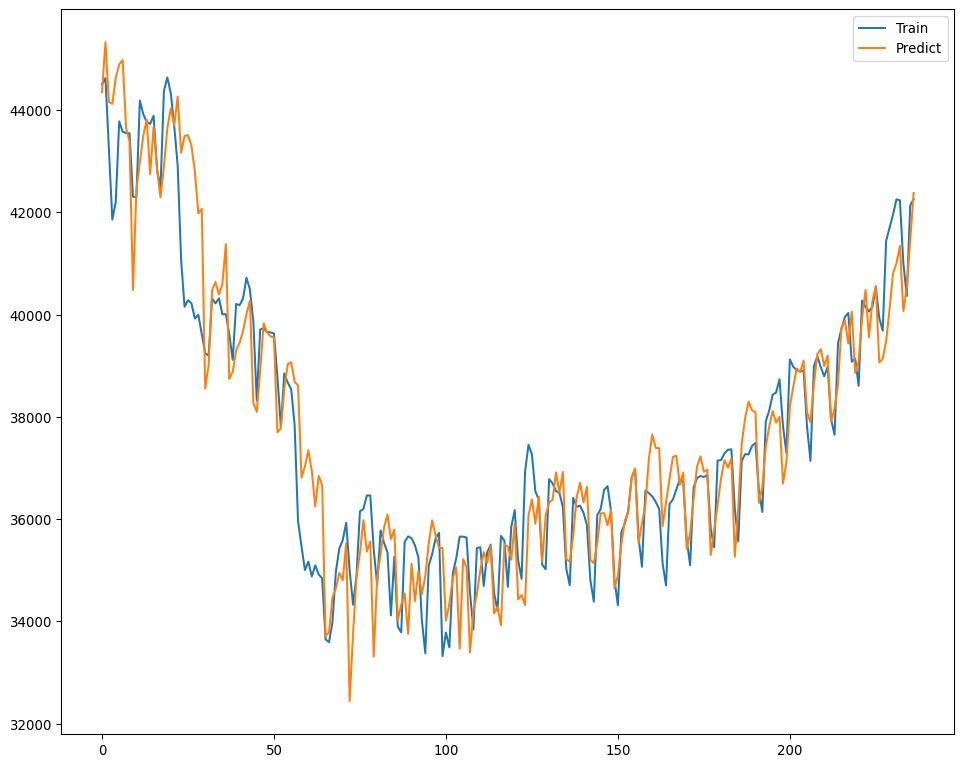

In [18]:
from_date = 1550
plt.figure(figsize=(12, 10), dpi=96)
#plt.plot(np.array(X_train.reset_index()["USE_FACT1"])[from_date:],label='Today')
plt.plot(np.array(Y_train.reset_index()["USE_PRED5"])[from_date:],label='Train')
plt.plot(Y_predict[:,4][from_date:],label='Predict')
plt.legend()
plt.show()

In [19]:
import pickle

with open('model.pkl', 'wb') as handle:
    pickle.dump(lr, handle, protocol=pickle.HIGHEST_PROTOCOL)

<br>

**Валидация на неизвестных данных**

<br>

In [20]:
X_train = data_train3m[test_length:].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[test_length:][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train2 = Y_train[["USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train2.set_index(Y_train["DATE"])
X_train

MONTH   DAY  WEEKDAY      USE_FACT  TEMP      VISIB     USE_FACT1  \
1818   10.0  23.0      4.0  42237.930556   4.8   6.110300  42254.805556   
1819   10.0  24.0      5.0  41015.000000   9.6   8.739153  42237.930556   
1820   10.0  25.0      6.0  40364.138889   4.9   7.047332  41015.000000   
1821   10.0  26.0      0.0  42136.791667   2.3   9.577778  40364.138889   
1822   10.0  27.0      1.0  42259.111111  -0.2   9.764444  42136.791667   
1823   10.0  28.0      2.0  42443.791667   0.5   9.947901  42259.111111   
1824   10.0  29.0      3.0  42416.041667   1.2   9.835926  42443.791667   
1825   10.0  30.0      4.0  42579.319444   2.8   9.217037  42416.041667   
1826   10.0  31.0      5.0  41311.430556   4.7   7.189012  42579.319444   
1827   11.0   1.0      6.0  40874.458333   4.1   8.083502  41311.430556   
1828   11.0   2.0      0.0  42526.055556   3.0  19.768530  40874.458333   
1829   11.0   3.0      1.0  42446.138889   2.0  18.311661  42526.055556   
1830   11.0   4.0      2.0  41336.569444   3.1   4.355118  42446.138889   
1831   11.0   5.0      3.0  42526.875000   4.0   5.525017  41336.569444   
1832   11.0   6.0      4.0  42647.458333   4.5   7.169776  42526.875000   
1833   11.0   7.0      5.0  41573.833333   3.0   8.864108  42647.458333   
1834   11.0   8.0      6.0  41086.347222   4.4   8.849248  41573.833333   
1835   11.0   9.0      0.0  43063.583333   0.8  10.247284  41086.347222   
1836   11.0  10.0      1.0  43478.513889   0.1   8.351852  43063.583333   
1837   11.0  11.0      2.0  43880.986111  -0.6  10.030653  43478.513889   
1838   11.0  12.0      3.0  44179.916667  -1.1   9.428448  43880.986111   
1839   11.0  13.0      4.0  44441.069444  -1.0   8.515732  44179.916667   
1840   11.0  14.0      5.0  43450.847222  -3.2   9.545088  44441.069444   
1841   11.0  15.0      6.0  43229.569444  -7.9  10.174109  43450.847222   
1842   11.0  16.0      0.0  45502.666667 -10.2  10.407928  43229.569444   
1843   11.0  17.0      1.0  45955.527778 -11.0  10.179250  45502.666667   
1844   11.0  18.0      2.0  46376.388889 -10.1  10.427937  45955.527778   
1845   11.0  19.0      3.0  46355.958333  -6.0  10.460009  46376.388889   
1846   11.0  20.0      4.0  46327.222222  -4.9  10.741887  46355.958333   
1847   11.0  21.0      5.0  44700.000000  -6.9  11.052143  46327.222222   

         USE_FACT3     USE_FACT5     USE_FACT7    USE_FACT14    USE_FACT30  \
1818  41696.736111  39686.583333  40540.625000  39081.625000  38913.888889   
1819  41958.444444  41443.055556  39935.986111  39142.375000  38891.027778   
1820  42254.805556  41696.736111  39686.583333  38608.069444  38907.416667   
1821  42237.930556  41958.444444  41443.055556  40276.375000  37806.694444   
1822  41015.000000  42254.805556  41696.736111  40152.486111  37141.125000   
1823  40364.138889  42237.930556  41958.444444  40065.208333  38994.555556   
1824  42136.791667  41015.000000  42254.805556  40154.430556  39186.861111   
1825  42259.111111  40364.138889  42237.930556  40540.625000  38970.875000   
1826  42443.791667  42136.791667  41015.000000  39935.986111  38794.972222   
1827  42416.041667  42259.111111  40364.138889  39686.583333  38982.000000   
1828  42579.319444  42443.791667  42136.791667  41443.055556  37947.819444   
1829  41311.430556  42416.041667  42259.111111  41696.736111  37651.138889   
1830  40874.458333  42579.319444  42443.791667  41958.444444  39439.555556   
1831  42526.055556  41311.430556  42416.041667  42254.805556  39726.527778   
1832  42446.138889  40874.458333  42579.319444  42237.930556  39952.972222   
1833  41336.569444  42526.055556  41311.430556  41015.000000  40035.763889   
1834  42526.875000  42446.138889  40874.458333  40364.138889  39081.625000   
1835  42647.458333  41336.569444  42526.055556  42136.791667  39142.375000   
1836  41573.833333  42526.875000  42446.138889  42259.111111  38608.069444   
1837  41086.347222  42647.458333  41336.569444  42443.791667  40276.375000   
1838  43063.583333  41573.833333  42526.87

In [21]:
Y_predict = lr.predict(X_train)
print(lr.coef_)
mean_absolute_error(Y_predict, Y_train2), r2_score(Y_predict, Y_train2)

[[ 3.23888853e+00 -4.11407219e+00  1.60953923e+02  1.18527815e+00
  -2.31067420e+01 -3.16686787e-01 -3.78068507e-01 -6.87414020e-02
   4.33509497e-01 -2.24731932e-01  1.48620558e-02 -3.61596343e-02
  -1.94115210e+00 -5.41848554e+00  1.34112453e+01 -2.07448918e+00
  -2.14588989e+00 -2.95452637e+00 -3.19271035e+02  2.64727703e+01
  -3.28254431e+01 -1.71517432e+00  2.49889362e+01]
 [-1.36005901e+00 -1.15390426e+01  5.81717935e+01  7.32078290e-01
  -5.70084145e+01 -3.45186557e-01 -4.26960265e-02 -3.38762701e-02
   7.83097776e-01 -5.16054280e-01  1.47692790e-02 -4.47145738e-02
   9.01210914e+00 -2.20707691e+00  3.43548343e+01 -1.16278489e+01
  -7.58964173e+00  2.72749926e+00 -1.47543638e+02 -7.37005378e+01
  -2.57774248e+01 -7.64236092e+00  3.23068606e+01]
 [-1.74152699e+01 -1.36077027e+01  1.78088816e+02  7.26050893e-01
  -6.81938087e+01  2.38568281e-01 -1.69483463e-01  3.25238410e-01
   4.02278666e-01 -3.70579084e-01  7.62856312e-02 -1.49385374e-01
   1.17309882e+01  7.02244107e+00  2.986

(596.2537454963099, 0.7637683091576284)

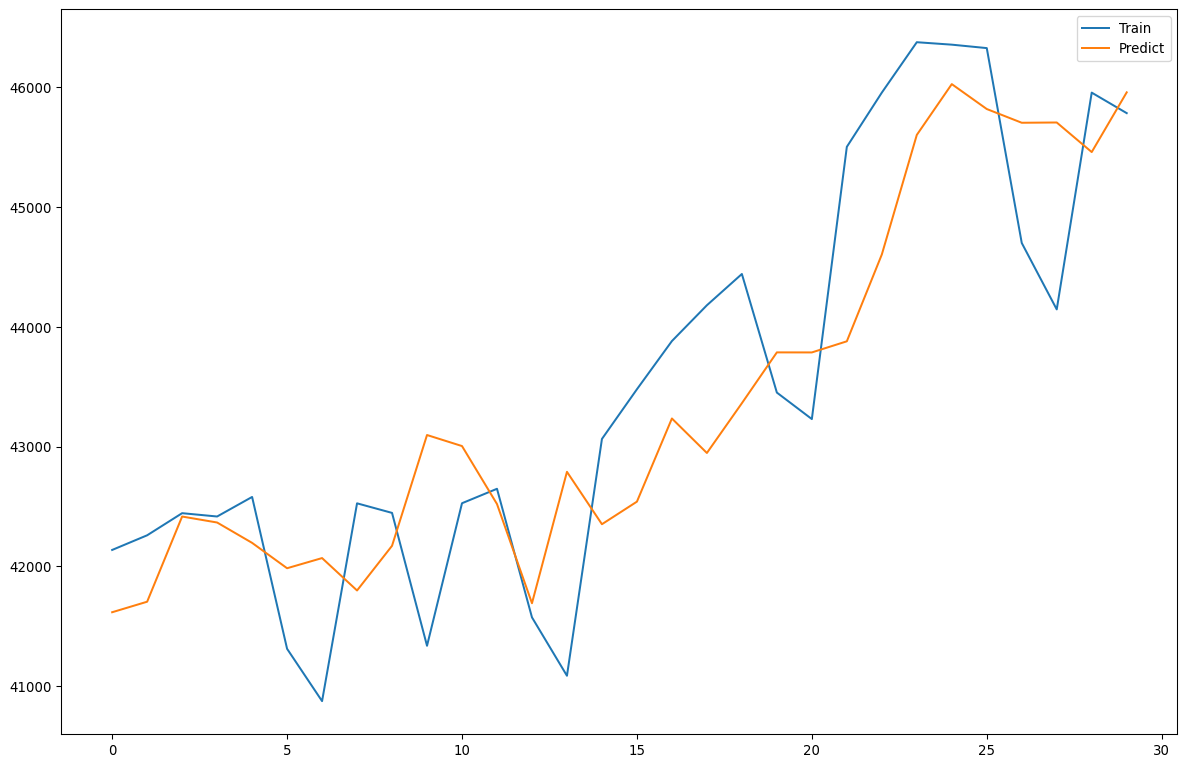

In [22]:
plt.figure(figsize=(15, 10), dpi=96)
#plt.plot(np.array(X_train.reset_index()["USE_FACT1"])[from_date:],label='Today')
plt.plot(np.array(Y_train.reset_index()["USE_PRED3"]),label='Train')
plt.plot(Y_predict[:,2],label='Predict')
plt.legend()
plt.show()

In [23]:
data_train

DATE  MONTH   DAY  WEEKDAY      USE_FACT  TEMP      VISIB  \
0    2015-11-01   11.0   1.0      6.0  42143.708333  -0.6   7.613333   
1    2015-11-02   11.0   2.0      0.0  44020.416667   2.3   6.420000   
2    2015-11-03   11.0   3.0      1.0  43557.458333   5.0   5.366667   
3    2015-11-04   11.0   4.0      2.0  41836.666667   4.2   8.113333   
4    2015-11-05   11.0   5.0      3.0  43676.013889   3.9   6.606667   
...         ...    ...   ...      ...           ...   ...        ...   
1848 2020-11-22   11.0  22.0      6.0  44145.444444  -7.0  10.424109   
1849 2020-11-23   11.0  23.0      0.0  45955.402778  -7.0  10.424109   
1850 2020-11-24   11.0  24.0      1.0  45784.166667  -7.0  10.424109   
1851 2020-11-25   11.0  25.0      2.0  45824.166667  -7.0  10.424109   
1852 2020-11-26   11.0  26.0      3.0  46075.694444  -7.0  10.424109   

            II       COMS       MSP  
0     2.000000  70.000000  0.000000  
1     2.000000  70.000000  0.000000  
2     2.000000  70.000000  0.000000  
3     2.000000  70.000000  0.000000  
4     2.000000  70.000000  0.000000  
...        ...        ...       ...  
1848  3.080093  59.222222  2.922222  
1849  1.526080  69.111111  2.922222  
1850  1.485802  70.444444  2.922222  
1851  1.487809  73.888889  2.922222  
1852  1.492593  74.666667  2.922222  

[1853 rows x 10 columns]

In [24]:
%%time

data_train = pd.DataFrame()
for r, d in data.iterrows():
    data_train.loc[r, "DATE"] = dt.datetime(int(d["YEAR"]), int(d["MONTH"]), int(d["DAY"]))
    data_train.loc[r, "MONTH"] = int(d["MONTH"])
    data_train.loc[r, "DAY"] = int(d["DAY"])
    data_train.loc[r, "WEEKDAY"] = int(d["WEEKDAY"])
    data_train.loc[r, "USE_FACT"] = d["USE_FACT"]
    data_train.loc[r, "TEMP"] = d["TEMP"]
    data_train.loc[r, "VISIB"] = d["VISIB"]
    data_train.loc[r, "II"] = d["II"]
    data_train.loc[r, "COMS"] = d["COMS"]
    data_train.loc[r, "MSP"] = d["MSP"]
data_train

BACK = 30
data_train3m = pd.DataFrame()
for r, d in data_train.iterrows():
    if r > BACK:
        data_train3m.loc[r, "DATE"] = d["DATE"]
        data_train3m.loc[r, "MONTH"] = d["MONTH"]
        data_train3m.loc[r, "DAY"] = d["DAY"]
        data_train3m.loc[r, "WEEKDAY"] = d["WEEKDAY"]
        data_train3m.loc[r, "USE_FACT"] = d["USE_FACT"]
        data_train3m.loc[r, "TEMP"] = d["TEMP"]
        data_train3m.loc[r, "VISIB"] = d["VISIB"]

        data_train3m.loc[r, "USE_FACT1"]  = data_train.loc[r - 1, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT3"]  = data_train.loc[r - 3, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT5"]  = data_train.loc[r - 5, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT7"]  = data_train.loc[r - 7, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT14"] = data_train.loc[r - 14, "USE_FACT"]
        data_train3m.loc[r, "USE_FACT30"] = data_train.loc[r - 30, "USE_FACT"]
    
        data_train3m.loc[r, "TEMP1"] = data_train.loc[r - 1]["TEMP"]
        data_train3m.loc[r, "TEMP3"] = data_train.loc[r - 3]["TEMP"]
        data_train3m.loc[r, "TEMP5"] = data_train.loc[r - 5]["TEMP"]
        data_train3m.loc[r, "TEMP7"] = data_train.loc[r - 7]["TEMP"]
        data_train3m.loc[r, "TEMP14"] = data_train.loc[r - 14]["TEMP"]
        data_train3m.loc[r, "TEMP30"] = data_train.loc[r - 30]["TEMP"]

        data_train3m.loc[r, "II"] = data_train.loc[r]["II"]
        data_train3m.loc[r, "II3"] = data_train.loc[r - 3]["II"]

        data_train3m.loc[r, "COMS"] = data_train.loc[r]["COMS"]
        data_train3m.loc[r, "COMS3"] = data_train.loc[r - 3]["COMS"]

        data_train3m.loc[r, "MSP"] = data_train.loc[r]["MSP"]
        
data_train3m

CPU times: user 14.5 s, sys: 953 µs, total: 14.5 s
Wall time: 14.6 s


DATE  MONTH   DAY  WEEKDAY      USE_FACT  TEMP      VISIB  \
31   2015-12-02   12.0   2.0      2.0  45997.125000  -0.4   6.756667   
32   2015-12-03   12.0   3.0      3.0  46161.666667  -1.4   7.063333   
33   2015-12-04   12.0   4.0      4.0  46242.638889  -1.5   7.700000   
34   2015-12-05   12.0   5.0      5.0  44494.750000  -1.0   5.286667   
35   2015-12-06   12.0   6.0      6.0  43615.013889   1.1   5.370000   
...         ...    ...   ...      ...           ...   ...        ...   
1848 2020-11-22   11.0  22.0      6.0  44145.444444  -7.0  10.424109   
1849 2020-11-23   11.0  23.0      0.0  45955.402778  -7.0  10.424109   
1850 2020-11-24   11.0  24.0      1.0  45784.166667  -7.0  10.424109   
1851 2020-11-25   11.0  25.0      2.0  45824.166667  -7.0  10.424109   
1852 2020-11-26   11.0  26.0      3.0  46075.694444  -7.0  10.424109   

         USE_FACT1     USE_FACT3     USE_FACT5     USE_FACT7    USE_FACT14  \
31    45941.472222  44002.027778  46336.416667  46098.555556  46767.500000   
32    45997.125000  45961.138889  44782.736111  46139.250000  47024.236111   
33    46161.666667  45941.472222  44002.027778  46336.416667  46950.111111   
34    46242.638889  45997.125000  45961.138889  44782.736111  45104.319444   
35    44494.750000  46161.666667  45941.472222  44002.027778  44374.847222   
...            ...           ...           ...           ...           ...   
1848  44700.000000  46355.958333  45955.527778  43229.569444  41086.347222   
1849  44145.444444  46327.222222  46376.388889  45502.666667  43063.583333   
1850  45955.402778  44700.000000  46355.958333  45955.527778  43478.513889   
1851  45784.166667  44145.444444  46327.222222  46376.388889  43880.986111   
1852  45824.166667  45955.402778  44700.000000  46355.958333  44179.916667   

        USE_FACT30  TEMP1  TEMP3  TEMP5  TEMP7  TEMP14  TEMP30        II  \
31    44020.416667    0.1   -5.5   -6.0   -1.4    -4.4     2.3  2.000000   
32    43557.458333   -0.4   -2.2   -5.2   -3.2    -4.1     5.0  2.000000   
33    41836.666667   -1.4    0.1   -5.5   -6.0    -2.4     4.2  2.000000   
34    43676.013889   -1.5   -0.4   -2.2   -5.2     0.8     3.9  2.000000   
35    44105.444444   -1.0   -1.4    0.1   -5.5     3.3     1.1  2.000000   
...            ...    ...    ...    ...    ...     ...     ...       ...   
1848  42237.930556   -6.9   -6.0  -11.0   -7.9     4.4     4.8  3.080093   
1849  41015.000000   -7.0   -4.9  -10.1  -10.2     0.8     9.6  1.526080   
1850  40364.138889   -7.0   -6.9   -6.0  -11.0     0.1     4.9  1.485802   
1851  42136.791667   -7.0   -7.0   -4.9  -10.1    -0.6     2.3  1.487809   
1852  42259.111111   -7.0   -7.0   -6.9   -6.0    -1.1    -0.2  1.492593   

           II3       COMS      COMS3       MSP  
31    2.000000  70.000000  70.000000  0.000000  
32    2.000000  70.000000  70.000000  0.000000  
33    2.000000  70.000000  70.000000  0.000000  
34    2.000000  70.000000  70.000000  0.000000  
35    2.000000  70.000000  70.000000  0.000000  
...        ...        ...        ...       ...  
1848  1.539969  59.222222  70.777778  2.922222  
1849  1.461420  69.111111  80.555556  2.922222  
1850  2.522994  70.444444  73.333333  2.922222  
1851  3.080093  73.888889  59.222222  2.922222  
1852  1.526080  74.666667  69.111111  2.922222  

[1822 rows x 24 columns]

In [25]:
X_train = data_train3m.drop(columns=["DATE"])
X_train.reset_index().drop(columns=["index"])[1815:][["DAY", "USE_FACT"]]

DAY      USE_FACT
1815  20.0  46327.222222
1816  21.0  44700.000000
1817  22.0  44145.444444
1818  23.0  45955.402778
1819  24.0  45784.166667
1820  25.0  45824.166667
1821  26.0  46075.694444

In [26]:
Y_predict = lr.predict(X_train)
pd.DataFrame(Y_predict)[1815:]

0             1             2             3             4
1815  45445.505144  44632.015135  45459.115280  46347.683715  46333.009890
1816  44752.674912  45841.866426  45957.676564  45834.678394  45507.738726
1817  45363.756192  46298.691154  46445.701410  46529.070512  46020.580774
1818  46653.386926  46528.409847  46324.085017  46381.890108  45183.145760
1819  46046.359589  46308.655549  45640.348633  44688.192351  44964.361427
1820  46136.171358  46101.125287  45329.208522  44470.377830  45428.689172
1821  45638.767489  44902.882646  45478.387409  46125.198304  46035.996788